# WeatherPy
----

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [84]:
# Import dependencies
import gmaps
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
import json
from citipy import citipy
import seaborn as sns
from scipy import stats
from scipy.stats import pearsonr

# Grab API keys
from config import (api_key)

#Output to csv
output_data_file = "../output_data/weather.csv"

# Range of latitudes and longitudes
lat_r = (-90, 90)
lng_r = (-180, 180)

# set pass through count
count = 0
set1 = 1

###### Generate Cities List

In [30]:
LL = []
cities = []
countries = []

# Create a set of random lat and lng combinations
lats = np.random.uniform(low=-90.000, high=90.000, size=1500)
lngs = np.random.uniform(low=-180.000, high=180.000, size=1500)


# Identify nearest city for each lat, lng combination
for LL in zip(lats, lngs):
    city = citipy.nearest_city(LL[0], LL[1]).city_name
    country = citipy.nearest_city(LL[0], LL[1]).country_code
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)
        countries.append(country.upper())

# Print the city count to confirm sufficient count
print(len(cities))

#Print the country count to confirm it matches city count
print(len(countries))

603
603


### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [3]:
#Create a dataframe to store the data
weatherdf = pd.DataFrame({'City': cities, 'Country': countries, 'Lat': "", 'Lng': "", 'Max Temp': "", 'Cloudiness': "",
                            'Humidity': "", 'Windspeed': "", 'Date': "",})

#Preview the dataframe
weatherdf.head()

,City,Country,Lat,Lng,Max Temp,Cloudiness,Humidity,Windspeed,Date
0,egvekinot,RU,,,,,,,
1,albany,AU,,,,,,,
2,plattsburgh,US,,,,,,,
3,boone,US,,,,,,,
4,prince rupert,CA,,,,,,,


In [6]:
# Variables to keep track of response number
record_n = 1
r_set = 1

#Add url
url = 'http://api.openweathermap.org/data/2.5/weather?units=imperial&q='

#API call each city
print('''
-----------------------------
Retrieving Data
-----------------------------''')
for index, row in weatherdf.iterrows(): 
    #Create the query url for the API call
    query_url = url + row['City'] + ',' + row['Country'] + '&APPID=' + api_key
    
    #API call
    response = requests.get(query_url).json()
    
    #Exception script in case the city is not found by the API call
    try: 
        #Meassage to alert the user that the data is being retrieved
        print(f'Processing Weather Data for Record {record_n} of Set {r_set} | {response["name"]}')
        
        #Input data into the dataframe
        weatherdf.loc[index, 'Cloudiness'] = response['clouds']['all']
        weatherdf.loc[index, 'Date'] = response['dt']
        weatherdf.loc[index, 'Humidity'] = response['main']['humidity']
        weatherdf.loc[index, 'Lat'] = response['coord']['lat']
        weatherdf.loc[index, 'Lng'] = response['coord']['lon']
        weatherdf.loc[index, 'Max Temp'] = response['main']['temp_max']
        weatherdf.loc[index, 'Windspeed'] = response['wind']['speed']
        
        #Increase the record count
        record_n += 1
        
    except (KeyError, IndexError):
        print("City not found, skipping.")
    
    #If statement to handle the API call limits
    if record_n == 51:
        r_set += 1
        record_n = 1
        time.sleep(30)
        
print('''
-----------------------------
Data Retrieval Complete
-----------------------------''')


-----------------------------
Retrieving Data
-----------------------------
Processing Weather Data for Record 1 of Set 1 | Egvekinot
Processing Weather Data for Record 2 of Set 1 | Albany
Processing Weather Data for Record 3 of Set 1 | Plattsburgh
Processing Weather Data for Record 4 of Set 1 | Boone
Processing Weather Data for Record 5 of Set 1 | Prince Rupert
Processing Weather Data for Record 6 of Set 1 | Hermanus
Processing Weather Data for Record 7 of Set 1 | Saint-Philippe
Processing Weather Data for Record 8 of Set 1 | Saint George
Processing Weather Data for Record 9 of Set 1 | Rikitea
Processing Weather Data for Record 10 of Set 1 | Bethel
Processing Weather Data for Record 11 of Set 1 | Nyurba
Processing Weather Data for Record 12 of Set 1 | Richards Bay
Processing Weather Data for Record 13 of Set 1 | Provideniya
Processing Weather Data for Record 14 of Set 1 | Northam
Processing Weather Data for Record 15 of Set 1 | Coahuayana Viejo
Processing Weather Data for Record 16 o

### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [11]:
# clean data to remove skipped cities
weatherdf['Max Temp'] = weatherdf['Max Temp'].replace("", np.nan)
weatherdf = weatherdf.dropna()
# Save to csv
# weatherdf.to_csv(output_data_file, index=False)
weatherdf.head()


,City,Country,Lat,Lng,Max Temp,Cloudiness,Humidity,Windspeed,Date
0,egvekinot,RU,66.3167,-179.1667,47.26,100,92,2.62,1627164681
1,albany,AU,-35.0169,117.8917,54.03,75,87,12.66,1627164681
2,plattsburgh,US,44.6995,-73.4529,81.36,1,46,3,1627164681
3,boone,US,39.0334,-92.3335,95.79,6,59,1.99,1627164681
4,prince rupert,CA,54.3161,-130.3201,60.46,81,78,2.48,1627164682


In [19]:
df3 = pd.read_csv(output_data_file)
df3.dtypes

City           object
Country        object
Lat           float64
Lng           float64
Max Temp      float64
Cloudiness      int64
Humidity        int64
Windspeed     float64
Date            int64
dtype: object

In [20]:
df3.describe()

,Lat,Lng,Max Temp,Cloudiness,Humidity,Windspeed,Date
count,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,5.410000e+02
mean,19.435139,19.541799,68.974436,51.341959,70.218115,8.228336,1.627165e+09
std,34.171023,92.260916,14.759523,38.848179,20.094880,5.779191,2.363282e+02
min,-54.800000,-179.166700,34.030000,0.000000,7.000000,0.000000,1.627164e+09
25%,-9.656700,-58.020900,57.090000,10.000000,61.000000,4.000000,1.627165e+09
50%,21.231100,24.730000,70.610000,47.000000,75.000000,6.910000,1.627165e+09
75%,49.099900,106.638100,79.920000,93.000000,85.000000,11.050000,1.627165e+09
max,78.218600,179.316700,103.780000,100.000000,100.000000,37.800000,1.627165e+09


## Inspect the data and remove the cities where the humidity > 100%.
----
Skip this step if there are no cities that have humidity > 100%. 

,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Date
count,550.000000,550.000000,550.000000,550.000000,550.000000,550.000000,5.500000e+02
mean,19.973545,17.124400,58.331400,67.890909,52.141818,8.544800,1.585764e+09
std,33.284840,91.595451,25.795297,20.864881,35.766469,6.078869,5.539674e+01
min,-54.800000,-179.170000,-11.340000,9.000000,0.000000,0.160000,1.585764e+09
25%,-8.077500,-64.627500,42.800000,55.000000,20.000000,4.525000,1.585764e+09
50%,23.630000,19.635000,64.940000,72.000000,57.000000,7.325000,1.585764e+09
75%,48.672500,97.350000,78.800000,83.000000,86.750000,11.410000,1.585764e+09
max,78.220000,179.320000,102.200000,100.000000,100.000000,46.080000,1.585764e+09


In [17]:
#  Get the indices of cities that have humidity over 100%.


Int64Index([], dtype='int64')

In [19]:
# Make a new DataFrame equal to the city data to drop all humidity outliers by index.
# Passing "inplace=False" will make a copy of the city_data DataFrame, which we call "clean_city_data".


,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,butaritari,3.07,172.79,83.32,74,84,10.42,KI,1593605283
1,yerbogachen,61.28,108.01,79.52,58,20,7.70,RU,1593605121
2,cape town,-33.93,18.42,73.00,77,27,4.70,ZA,1593605039
3,touba,8.28,-7.68,79.97,75,82,3.58,CI,1593605284
4,jamestown,42.10,-79.24,64.00,88,1,6.93,US,1593605284


## Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

## Latitude vs. Temperature Plot

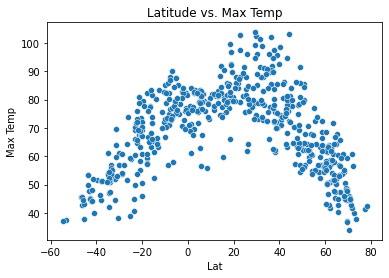

In [31]:
sns.scatterplot(data=df3, x="Lat", y="Max Temp").set_title(f'Latitude vs. Max Temp')
plt.show()

In [ ]:
## Latitude vs. Humidity Plot

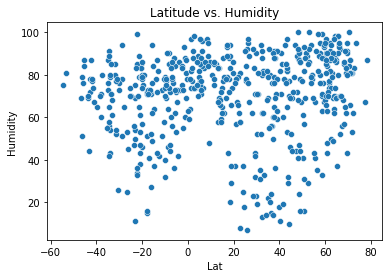

In [33]:
sns.scatterplot(data=df3, x="Lat", y="Humidity").set_title(f'Latitude vs. Humidity')
plt.show()

## Latitude vs. Cloudiness Plot

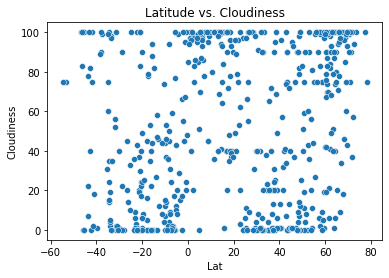

In [34]:
sns.scatterplot(data=df3, x="Lat", y="Cloudiness").set_title(f'Latitude vs. Cloudiness')
plt.show()

## Latitude vs. Wind Speed Plot

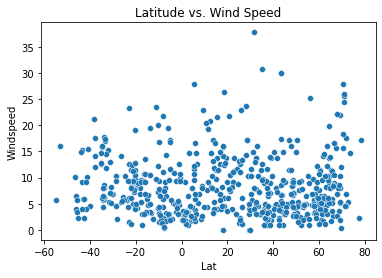

In [36]:
sns.scatterplot(data=df3, x="Lat", y="Windspeed").set_title(f'Latitude vs. Wind Speed')
plt.show()

## Linear Regression

In [38]:
north = df3.loc[df3['Lat']>=0]
south = df3.loc[df3['Lat']<0]

####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

r=-0.6692709124176608, p=2.271319466382281e-48


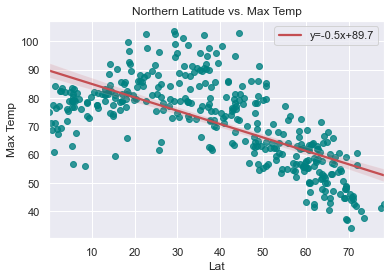

In [102]:
#sns.regplot(data=north, x="Lat", y="Max Temp").set_title(f'Latitude vs. Max Temp')
sns.set_theme(color_codes=True)
slope, intercept, r_value, p_value, std_err = stats.linregress(north['Lat'],north['Max Temp'])
ax = sns.regplot(x="Lat", y="Max Temp", data=north, color='r', scatter_kws={"color": "teal"}, 
 line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
ax.set_title(f'Northern Latitude vs. Max Temp')
ax.legend()
print(f'r={r_value}, p={p_value}')
plt.show()


####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

r=0.8278116048940141, p=2.664256171368718e-46


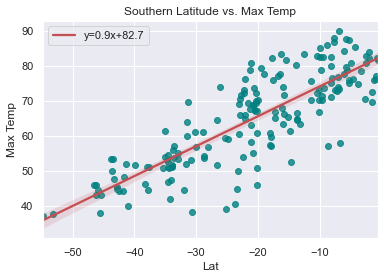

In [103]:
sns.set_theme(color_codes=True)
slope, intercept, r_value, p_value, std_err = stats.linregress(south['Lat'],south['Max Temp'])
ax = sns.regplot(x="Lat", y="Max Temp", data=south, color='r', scatter_kws={"color": "teal"}, 
 line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
ax.set_title(f'Southern Latitude vs. Max Temp')
ax.legend()
print(f'r={r_value}, p={p_value}')
plt.show()

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

r=0.05099647052781944, p=0.3332701687637828


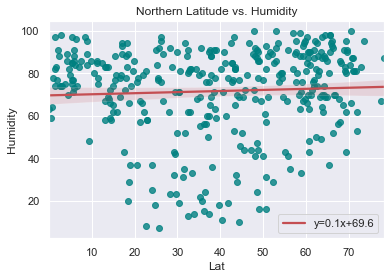

In [104]:
sns.set_theme(color_codes=True)
slope, intercept, r_value, p_value, std_err = stats.linregress(north['Lat'],north['Humidity'])
ax = sns.regplot(x="Lat", y="Humidity", data=north, color='r', scatter_kws={"color": "teal"}, 
 line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
ax.set_title(f'Northern Latitude vs. Humidity')
ax.legend()
print(f'r={r_value}, p={p_value}')
plt.show()

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

r=-0.002591965973774942, p=0.972530073960671


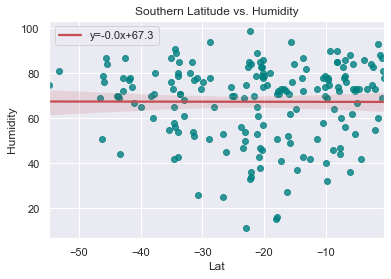

In [105]:
sns.set_theme(color_codes=True)
slope, intercept, r_value, p_value, std_err = stats.linregress(south['Lat'],south['Humidity'])
ax = sns.regplot(x="Lat", y="Humidity", data=south, 
                 color='r', scatter_kws={"color": "teal"},
 line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
ax.set_title(f'Southern Latitude vs. Humidity')
ax.legend()
print(f'r={r_value}, p={p_value}')
plt.show()

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

r=-0.046647799845527436, p=0.37618512004004656


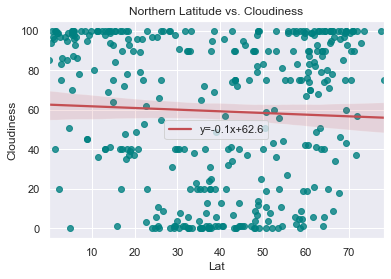

In [107]:
sns.set_theme(color_codes=True)
slope, intercept, r_value, p_value, std_err = stats.linregress(north['Lat'],north['Cloudiness'])
ax = sns.regplot(x="Lat", y="Cloudiness", data=north, color='r', scatter_kws={"color": "teal"}, 
 line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
ax.set_title(f'Northern Latitude vs. Cloudiness')
ax.legend()
print(f'r={r_value}, p={p_value}')
plt.show()

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

r=-0.16536157299990434, p=0.02695702427179632


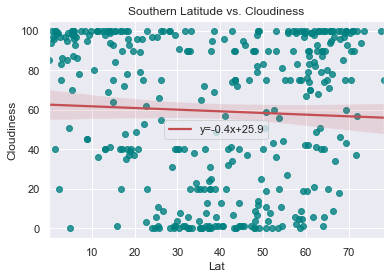

In [115]:
sns.set_theme(color_codes=True)
slope, intercept, r_value, p_value, std_err = stats.linregress(south['Lat'],south['Cloudiness'])
ax = sns.regplot(x="Lat", y="Cloudiness", data=north, color='r', scatter_kws={"color": "teal"}, 
 line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
ax.set_title(f'Southern Latitude vs. Cloudiness')
ax.legend()
print(f'r={r_value}, p={p_value}')
plt.show()

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

r=-0.002705125397329228, p=0.9590939513575908


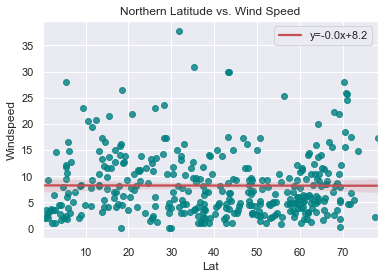

In [112]:
sns.set_theme(color_codes=True)
slope, intercept, r_value, p_value, std_err = stats.linregress(north['Lat'],north['Windspeed'])
ax = sns.regplot(x="Lat", y="Windspeed", data=north, color='r', scatter_kws={"color": "teal"}, 
 line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
ax.set_title(f'Northern Latitude vs. Wind Speed')
ax.legend()
print(f'r={r_value}, p={p_value}')
plt.show()

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

r=-0.15120477843660185, p=0.043337646020293705


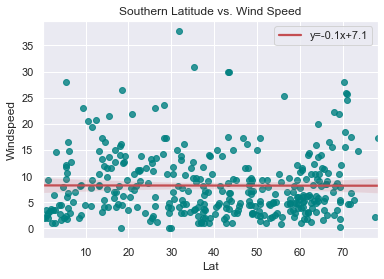

In [114]:
sns.set_theme(color_codes=True)
slope, intercept, r_value, p_value, std_err = stats.linregress(south['Lat'],south['Windspeed'])
ax = sns.regplot(x="Lat", y="Windspeed", data=north, color='r', scatter_kws={"color": "teal"}, 
 line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
ax.set_title(f'Southern Latitude vs. Wind Speed')
ax.legend()
print(f'r={r_value}, p={p_value}')
plt.show()